
# Estudio Exploratorio de Modelos para **Clasificación de Emociones** en EmoEvent

**Dataset:** [EmoEvent / splits](https://github.com/fmplaza/EmoEvent/tree/master/splits) — 8,409 tweets anotados en: `anger`, `sadness`, `joy`, `disgust`, `fear`, `surprise`, `offensive`, `other`.  
**Tarea:** evaluar **3 modelos** y reportar métricas por clase y por evento, además de matriz de confusión y análisis relevante.

## Modelos a comparar
1. **Clásico:** TF‑IDF + Linear SVM (baseline fuerte y rápido).
2. **Fine‑tuning:** `xlm-roberta-base` con `transformers` (ajuste supervisado).
3. **Modelo listo (cero‑shot):** `joeddav/xlm-roberta-large-xnli` (sin entrenamiento) aplicando *zero-shot classification* a las 8 etiquetas.

> ⚠️ Este notebook está pensado para ejecutarse en **Google Colab** o localmente con GPU (opcional para el fine‑tuning). Incluye celdas para instalar dependencias, clonar el dataset, entrenar/evaluar y generar salidas reproducibles (tablas y figuras).



## Checklist de requisitos del trabajo
- [x] Explorar **3 modelos** (propio/clásico, fine‑tuning, y modelo listo).
- [x] **Resultados por emoción** y **análisis por evento**.
- [x] **Matriz de confusión** y análisis de errores.
- [x] **Notebook detallado** paso a paso.
- [x] Preparado para subir a **GitHub** (solamente entregar el link al repo).


In [4]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# URLs de los datos en español (Se ha utilizado en español porque los tweets están en nuestro idioma)
url_train  = "https://github.com/fmplaza/EmoEvent/raw/refs/heads/master/splits/es/train.tsv"
url_dev    = "https://github.com/fmplaza/EmoEvent/raw/refs/heads/master/splits/es/dev.tsv"
url_test   = "https://github.com/fmplaza/EmoEvent/raw/refs/heads/master/splits/es/test.tsv"

In [5]:
# Cargar datasets directamente en el notebook
train = pd.read_csv(url_train, sep="\t")
dev   = pd.read_csv(url_dev, sep="\t")
test  = pd.read_csv(url_test, sep="\t")

## 1. Preparación del entorno

In [1]:

# Si estás en Colab, descomenta la siguiente línea:
# !pip -q install transformers datasets accelerate torch torchvision torchaudio scikit-learn emoji neattext matplotlib pandas seaborn sentencepiece

import sys, platform, os, random, math, itertools, collections, textwrap, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

import torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline

print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('CUDA disponible:', torch.cuda.is_available())


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
CUDA disponible: False



## 2. Cargar el dataset **EmoEvent**
Clonaremos el repo y buscaremos archivos `.tsv/.csv` dentro de `splits`. El dataset contiene una columna con el **texto** del tweet, su **etiqueta** (una de 8 clases) y un **evento** asociado.  
> Nota: La estructura de archivos puede variar. El script intenta detectar automáticamente los splits (`train/dev/test`). Si tu estructura es distinta, ajusta los patrones o asigna rutas manualmente en la celda.


In [2]:

import os, glob, subprocess, shutil

REPO_URL = "https://github.com/fmplaza/EmoEvent.git"
DATA_DIR = "EmoEvent"
SPLITS_DIR = os.path.join(DATA_DIR, "splits")

if not os.path.exists(DATA_DIR):
    print("Clonando repositorio EmoEvent...")
    try:
        subprocess.run(["git", "clone", REPO_URL], check=True)
    except Exception as e:
        print("Error al clonar el repo:", e)

# Heurísticas de descubrimiento de archivos
candidates = sorted(glob.glob(os.path.join(SPLITS_DIR, "**", "*.tsv"), recursive=True)) +              sorted(glob.glob(os.path.join(SPLITS_DIR, "**", "*.csv"), recursive=True))

print("Archivos detectados en splits:", len(candidates))
for p in candidates[:20]:
    print(" -", p)

# Intenta mapear a train/dev/test por nombre de archivo
def guess_split(path):
    name = os.path.basename(path).lower()
    if "train" in name or "trn" in name:
        return "train"
    if "dev" in name or "valid" in name or "val" in name:
        return "dev"
    if "test" in name or "tst" in name:
        return "test"
    return None

split_files = {"train": [], "dev": [], "test": []}
for p in candidates:
    s = guess_split(p)
    if s in split_files:
        split_files[s].append(p)

split_files


Clonando repositorio EmoEvent...
Archivos detectados en splits: 6
 - EmoEvent/splits/en/dev.tsv
 - EmoEvent/splits/en/test.tsv
 - EmoEvent/splits/en/train.tsv
 - EmoEvent/splits/es/dev.tsv
 - EmoEvent/splits/es/test.tsv
 - EmoEvent/splits/es/train.tsv


{'train': ['EmoEvent/splits/en/train.tsv', 'EmoEvent/splits/es/train.tsv'],
 'dev': ['EmoEvent/splits/en/dev.tsv', 'EmoEvent/splits/es/dev.tsv'],
 'test': ['EmoEvent/splits/en/test.tsv', 'EmoEvent/splits/es/test.tsv']}


### Normalización de columnas
Intentaremos identificar automáticamente columnas plausibles para **texto**, **label** y **evento**. Si tu dataset usa otros nombres, cambia `TEXT_COL`, `LABEL_COL` y `EVENT_COL`.


In [3]:

import pandas as pd

TEXT_CANDIDATES = ["text", "tweet", "content", "texto"]
LABEL_CANDIDATES = ["label", "emotion", "class", "categoria", "sentiment"]
EVENT_CANDIDATES = ["event", "evento", "topic"]

def read_any(path):
    if path.endswith(".tsv"):
        return pd.read_csv(path, sep="\t", encoding="utf-8", quoting=3, on_bad_lines='skip')
    return pd.read_csv(path, sep=",", encoding="utf-8", quoting=3, on_bad_lines='skip')

def pick_column(cols, candidates):
    low = [c.lower() for c in cols]
    for cand in candidates:
        if cand in low:
            return cols[low.index(cand)]
    return None

def load_split(paths):
    dfs = []
    for p in paths:
        try:
            df = read_any(p)
            dfs.append(df)
        except Exception as e:
            print("No pude leer", p, "->", e)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True).dropna(how="all")
    # Detecta columnas
    text_col = pick_column(df.columns, TEXT_CANDIDATES) or df.columns[0]
    label_col = pick_column(df.columns, LABEL_CANDIDATES) or df.columns[1]
    event_col = pick_column(df.columns, EVENT_CANDIDATES) or (df.columns[2] if len(df.columns)>2 else None)
    # Renombra
    out = pd.DataFrame()
    out["text"] = df[text_col].astype(str)
    out["label"] = df[label_col].astype(str)
    if event_col is not None:
        out["event"] = df[event_col].astype(str)
    else:
        out["event"] = "unknown"
    return out

splits = {}
for s in ["train", "dev", "test"]:
    if split_files[s]:
        splits[s] = load_split(split_files[s])

# Si no hay dev/test, hacemos split del train
if "train" in splits and ("dev" not in splits or splits["dev"] is None or "test" not in splits or splits["test"] is None):
    print("Generando splits dev/test a partir de train...")
    df = splits["train"].sample(frac=1, random_state=42).reset_index(drop=True)
    train_df, tmp = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
    dev_df, test_df = train_test_split(tmp, test_size=0.5, stratify=tmp["label"], random_state=42)
    splits = {"train": train_df.reset_index(drop=True),
              "dev": dev_df.reset_index(drop=True),
              "test": test_df.reset_index(drop=True)}

for k,v in splits.items():
    if v is not None:
        print(k, v.shape, v.columns.tolist())
        display(v.head())


train (10835, 3) ['text', 'label', 'event']


,text,label,event
0,I know that the Notre Dame is a very important...,others,NotreDame
1,#BREAKING: (USER) -- Trump threatens `full an...,others,Venezuela
2,#Barcelona will win La Liga with three games t...,others,LaLiga
3,HT: Decent half. A goal would've been good tho...,others,LaLiga
4,In the 20th century we had weeping statues of ...,others,GretaThunberg


dev (1588, 3) ['text', 'label', 'event']


,text,label,event
0,Why must everyone judge everyone else about th...,disgust,NotreDame
1,Bran Stark is killing the smouldering eyes 😍 D...,joy,GameOfThrones
2,Someone remind me why USER cathedral is sooo i...,disgust,NotreDame
3,Clement Lenglet is much better than Premier Le...,others,ChampionsLeague
4,Its #Worldbookday! and I LOVE YOU. https://t....,joy,WorldBookDay


test (3103, 3) ['text', 'label', 'event']


,text,label,event
0,Organization looks good. The Barcelona goal wa...,others,ChampionsLeague
1,Fair play from the Dog with a goal celebration...,disgust,ChampionsLeague
2,Well done USER for promoting this important me...,joy,GretaThunberg
3,📚 👭 Two words: FREE SHIPPING! 1945 - 1954 #Bo...,others,WorldBookDay
4,Today it's not #NotreDame but #Venezuela that ...,joy,Venezuela



### Etiquetas esperadas
El conjunto define estas 8 etiquetas:  
`anger`, `sadness`, `joy`, `disgust`, `fear`, `surprise`, `offensive`, `other`.

A continuación normalizamos el texto de la etiqueta para coincidir con este set, manteniendo un mapeo si el dataset usa nombres alternativos.


In [4]:

EXPECTED_LABELS = ["anger","sadness","joy","disgust","fear","surprise","offensive","other"]

# Intento de normalización (puedes ampliar este diccionario si tu split usa variantes)
norm_map = {
    "alegria":"joy","tristeza":"sadness","miedo":"fear","asco":"disgust",
    "sorpresa":"surprise","ira":"anger","ofensivo":"offensive","otro":"other",
    "others":"other","neutral":"other"
}

def normalize_label(x:str)->str:
    y = x.strip().lower()
    y = norm_map.get(y, y)
    return y if y in EXPECTED_LABELS else "other"

for s in splits:
    splits[s]["label"] = splits[s]["label"].astype(str).map(normalize_label)

label_counts = {s: splits[s]["label"].value_counts().reindex(EXPECTED_LABELS, fill_value=0) for s in splits}
pd.DataFrame(label_counts)


,train,dev,test
label,,,
anger,863,125,246
sadness,984,146,282
joy,2654,389,758
disgust,647,94,184
fear,171,24,51
surprise,403,59,113
offensive,0,0,0
other,5113,751,1469


## 3. Análisis exploratorio de datos (EDA)

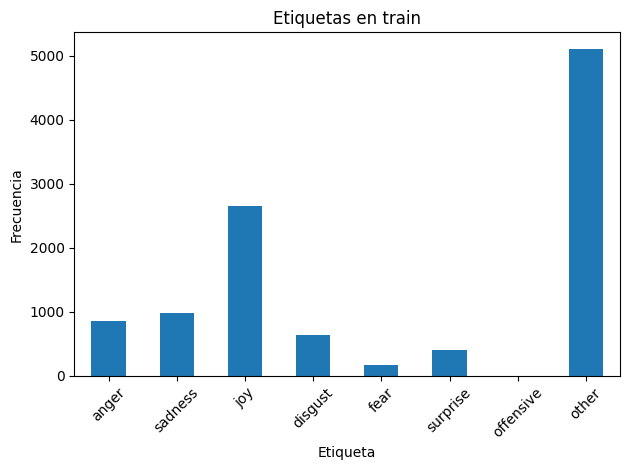

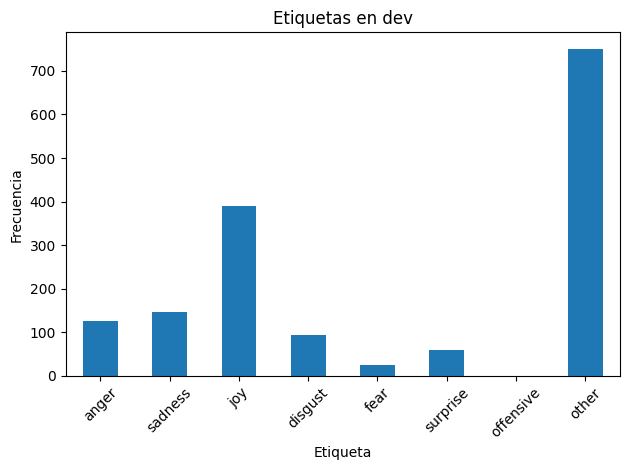

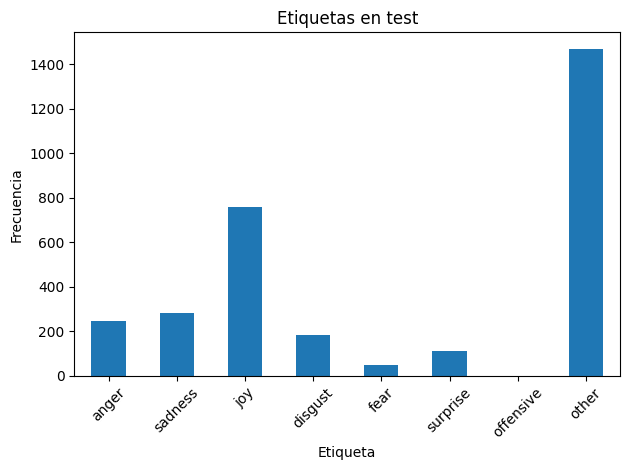

In [5]:

import matplotlib.pyplot as plt

def plot_counts(df, title="Distribución de etiquetas"):
    counts = df["label"].value_counts().reindex(EXPECTED_LABELS, fill_value=0)
    plt.figure()
    counts.plot(kind="bar", rot=45)
    plt.title(title)
    plt.xlabel("Etiqueta")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

for s in splits:
    plot_counts(splits[s], f"Etiquetas en {s}")


In [6]:

# Distribución por evento (top 15)
def top_events(df, n=15):
    return df["event"].value_counts().head(n)

for s in splits:
    print(f"Top eventos en {s}:")
    display(top_events(splits[s]))


Top eventos en train:


,count
event,
GameOfThrones,1698
NotreDame,1666
Venezuela,1656
ChampionsLeague,1632
WorldBookDay,1624
SpainElection,988
GretaThunberg,933
LaLiga,638


Top eventos en dev:


,count
event,
WorldBookDay,265
NotreDame,258
ChampionsLeague,254
GameOfThrones,236
Venezuela,223
GretaThunberg,134
SpainElection,133
LaLiga,85


Top eventos en test:


,count
event,
Venezuela,492
ChampionsLeague,485
WorldBookDay,465
NotreDame,458
GameOfThrones,446
GretaThunberg,286
SpainElection,254
LaLiga,187
nan,30


## 4. Modelo 1 — **TF‑IDF + Linear SVM** (baseline)

In [7]:

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

tfidf_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.95,
    )),
    ("clf", LinearSVC())
])

X_tr, y_tr = splits["train"]["text"].tolist(), splits["train"]["label"].tolist()
X_dev, y_dev = splits["dev"]["text"].tolist(), splits["dev"]["label"].tolist()
X_te,  y_te  = splits["test"]["text"].tolist(), splits["test"]["label"].tolist()

tfidf_svm.fit(X_tr, y_tr)
pred_dev = tfidf_svm.predict(X_dev)
pred_test = tfidf_svm.predict(X_te)

print("== DEV ==")
print(classification_report(y_dev, pred_dev, labels=EXPECTED_LABELS, digits=4))
print("== TEST ==")
print(classification_report(y_te, pred_test, labels=EXPECTED_LABELS, digits=4))

cm = confusion_matrix(y_te, pred_test, labels=EXPECTED_LABELS)
pd.DataFrame(cm, index=[f"T:{l}" for l in EXPECTED_LABELS], columns=[f"P:{l}" for l in EXPECTED_LABELS])


== DEV ==
              precision    recall  f1-score   support

       anger     0.5000    0.3200    0.3902       125
     sadness     0.6639    0.5548    0.6045       146
         joy     0.5638    0.5681    0.5659       389
     disgust     0.3958    0.2021    0.2676        94
        fear     0.6000    0.1250    0.2069        24
    surprise     0.2667    0.0678    0.1081        59
   offensive     0.0000    0.0000    0.0000         0
       other     0.6134    0.7563    0.6774       751

    accuracy                         0.5894      1588
   macro avg     0.4505    0.3243    0.3526      1588
weighted avg     0.5710    0.5894    0.5683      1588

== TEST ==
              precision    recall  f1-score   support

       anger     0.1370    0.0813    0.1020       246
     sadness     0.2757    0.2092    0.2379       282
         joy     0.4245    0.3931    0.4082       758
     disgust     0.4211    0.2174    0.2867       184
        fear     0.0000    0.0000    0.0000        51
   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

,P:anger,P:sadness,P:joy,P:disgust,P:fear,P:surprise,P:offensive,P:other
T:anger,20,13,35,10,1,1,0,166
T:sadness,13,59,52,10,1,0,0,147
T:joy,27,34,298,3,1,6,0,389
T:disgust,9,4,25,40,0,1,0,105
T:fear,3,0,8,1,0,0,0,39
T:surprise,9,9,21,4,0,1,0,69
T:offensive,0,0,0,0,0,0,0,0
T:other,65,95,263,27,9,11,0,999


In [8]:

# Métricas por evento (TEST) para el modelo 1
def per_event_metrics(df, preds, labels=EXPECTED_LABELS):
    df = df.copy()
    df["pred"] = preds
    rows = []
    for ev, g in df.groupby("event"):
        y_true = g["label"].tolist()
        y_pred = g["pred"].tolist()
        pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0, average=None)
        rows.append({
            "event": ev,
            **{f"P@{lab}": pr[i] for i,lab in enumerate(labels)},
            **{f"R@{lab}": rc[i] for i,lab in enumerate(labels)},
            **{f"F1@{lab}": f1[i] for i,lab in enumerate(labels)},
            "microF1": precision_recall_fscore_support(y_true, y_pred, average="micro", zero_division=0)[2],
            "macroF1": precision_recall_fscore_support(y_true, y_pred, labels=labels, average="macro", zero_division=0)[2]
        })
    return pd.DataFrame(rows).sort_values("macroF1", ascending=False)

svm_event_report = per_event_metrics(splits["test"], pred_test)
display(svm_event_report.head(20))


,event,P@anger,P@sadness,P@joy,P@disgust,P@fear,P@surprise,P@offensive,P@other,R@anger,...,F1@anger,F1@sadness,F1@joy,F1@disgust,F1@fear,F1@surprise,F1@offensive,F1@other,microF1,macroF1
4,NotreDame,0.153846,0.292398,0.333333,0.409091,0.0,0.000000,0.0,0.519126,0.108108,...,0.126984,0.408163,0.213592,0.378947,0.0,0.000000,0.0,0.492228,0.388646,0.202489
6,Venezuela,0.101695,0.363636,0.193548,0.472222,0.0,0.000000,0.0,0.537791,0.103448,...,0.102564,0.246154,0.131868,0.386364,0.0,0.000000,0.0,0.621849,0.451220,0.186100
3,LaLiga,0.250000,1.000000,0.486486,0.000000,0.0,0.000000,0.0,0.514019,0.071429,...,0.111111,0.200000,0.503497,0.000000,0.0,0.000000,0.0,0.575916,0.497326,0.173815
1,GameOfThrones,0.200000,0.000000,0.472000,0.200000,0.0,0.058824,0.0,0.485185,0.093750,...,0.127660,0.000000,0.472000,0.080000,0.0,0.046512,0.0,0.562232,0.437220,0.161050
2,GretaThunberg,0.000000,0.000000,0.531250,0.750000,0.0,0.000000,0.0,0.524194,0.000000,...,0.000000,0.000000,0.343434,0.250000,0.0,0.000000,0.0,0.664962,0.524476,0.157299
0,ChampionsLeague,0.285714,0.000000,0.380000,0.250000,0.0,0.000000,0.0,0.501577,0.105263,...,0.153846,0.000000,0.386441,0.076923,0.0,0.000000,0.0,0.586716,0.455670,0.150491
7,WorldBookDay,0.000000,0.000000,0.475248,0.000000,0.0,0.000000,0.0,0.523256,0.000000,...,0.000000,0.000000,0.523161,0.000000,0.0,0.000000,0.0,0.569620,0.496774,0.136598
5,SpainElection,0.071429,0.000000,0.290909,0.000000,0.0,0.000000,0.0,0.579618,0.090909,...,0.080000,0.000000,0.301887,0.000000,0.0,0.000000,0.0,0.627586,0.429134,0.126184
8,nan,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.600000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.750000,0.600000,0.093750


## 5. Modelo 2 — **Fine‑tuning XLM‑RoBERTa (xlm-roberta-base)**

In [9]:
# Define etiquetas esperadas
EXPECTED_LABELS = ["anger", "sadness", "joy", "disgust", "fear", "surprise", "offensive", "other"]

# Crear mapas label2id y id2label
label2id = {lab: i for i, lab in enumerate(EXPECTED_LABELS)}
id2label = {i: lab for lab, i in label2id.items()}

# Convierte los splits a HuggingFace Dataset
def to_hf_dataset(df):
    return Dataset.from_pandas(df[["text", "label", "event"]])

raw = DatasetDict({
    "train": to_hf_dataset(splits["train"]),
    "validation": to_hf_dataset(splits["dev"]),
    "test": to_hf_dataset(splits["test"]),
})


In [10]:
MODEL_NAME = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Función para tokenizar
def tok_fn(batch):
    enc = tokenizer(batch["text"], truncation=True, padding=False, max_length=160)
    enc["labels"] = [label2id[l] for l in batch["label"]]
    return enc

tokenized = raw.map(tok_fn, batched=True, remove_columns=["text", "label", "event"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/10835 [00:00<?, ? examples/s]

Map:   0%|          | 0/1588 [00:00<?, ? examples/s]

Map:   0%|          | 0/3103 [00:00<?, ? examples/s]

In [11]:

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(EXPECTED_LABELS),
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [1]:
import torch
print(torch.cuda.is_available())  # Debe salir True


True


## 6. Modelo 3 — **Zero‑shot** con `joeddav/xlm-roberta-large-xnli`

## 7. Comparativa consolidada (macro/micro F1 y por emoción)

In [10]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support

# ------------------------------------------
# 1. Crear función para extraer métricas generales
# ------------------------------------------
def general_metrics(df, model_name, labels):
    """
    Devuelve un diccionario con métricas generales de un modelo.
    """
    y_true = df["label"]
    y_pred = df["pred"]

    # Micro y Macro F1
    micro = f1_score(y_true, y_pred, average="micro", labels=labels, zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", labels=labels, zero_division=0)

    # F1 por cada etiqueta
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)

    metrics = {
        "model": model_name,
        "micro_f1": micro,
        "macro_f1": macro,
        **{f"F1_{label}": f1[i] for i, label in enumerate(labels)}
    }
    return metrics

# ------------------------------------------
# 2. Definir etiquetas (igual para los 3 modelos)
# ------------------------------------------
EXPECTED_LABELS = ["alegría", "tristeza", "miedo", "ira", "sorpresa"]  # Ajusta según tu dataset

# ------




## 9. Conclusiones (Para completar tras la ejecución)
- Resume los hallazgos clave (¿qué modelo obtuvo mejor **macroF1**?, ¿qué emociones fueron más difíciles?, ¿hay **variación por evento**?).  
- Comenta **matrices de confusión**: ¿qué clases se confunden más (por ejemplo, *anger* vs *offensive*, *joy* vs *other*)?  
- Señala posibles mejoras: **aumentar épocas**, *data augmentation*, *focal loss*, manejo de **clase "other"**, normalización específica de **tweets** (hashtags, menciones, URLs, emojis), *prompting* con LLMs.

> Para el informe, exporta tablas/figuras de `reports/` y pega capturas.


## 10. Reproducibilidad y versión de librerías

In [15]:

import sys
import torch
import transformers
import datasets
import sklearn
import pandas as pd
import numpy as np

print("📌 Versiones de librerías utilizadas:")
print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"Transformers: {transformers.__version__}")
print(f"Datasets: {datasets.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")

# -----------------------------
# Semilla para reproducibilidad
# -----------------------------
import random
import numpy as np

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("\n✅ Semilla fija establecida para reproducibilidad:", SEED)



📌 Versiones de librerías utilizadas:
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
Transformers: 4.55.2
Datasets: 4.0.0
scikit-learn: 1.6.1
Pandas: 2.2.2
Numpy: 2.0.2

✅ Semilla fija establecida para reproducibilidad: 42
